In [ ]:
# Import libraries
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import pickle

In [ ]:
# Load the dataset
newsgroups = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.DataFrame({'text': newsgroups.data, 'target': newsgroups.target})

In [ ]:
data.shape

(18846, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18846 non-null  object
 1   target  18846 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 294.6+ KB


In [ ]:
data.describe()

target
count  18846.000000
mean       9.293166
std        5.562798
min        0.000000
25%        5.000000
50%        9.000000
75%       14.000000
max       19.000000

In [ ]:
data.columns

Index(['text', 'target'], dtype='object')

In [ ]:
data.head()

text  target
0  From: Mamatha Devineni Ratnam <mr47+@andrew.cm...      10
1  From: mblawson@midway.ecn.uoknor.edu (Matthew ...       3
2  From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...      17
3  From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...       3
4  From: Alexander Samuel McDiarmid <am2o+@andrew...       4

In [ ]:
data.isnull().sum()

text      0
target    0
dtype: int64

In [ ]:
data.isnull().any(axis=1).sum()

0

In [ ]:
print("Unique target values:", data['target'].nunique())

Unique target values: 20


In [ ]:
print("Target categories:", newsgroups.target_names)

Target categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


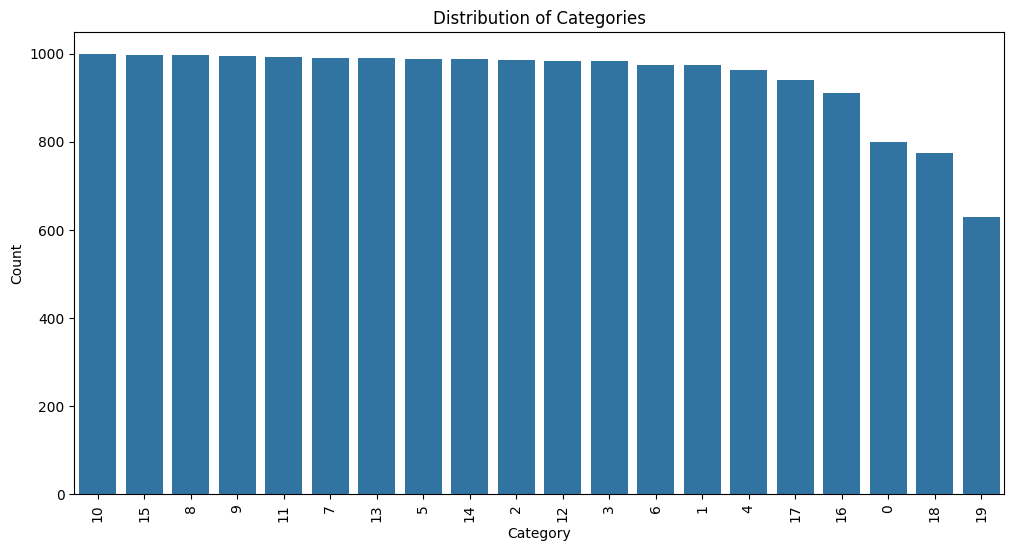

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='target', order=data['target'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [ ]:
print("Distribution of target values:")
print(data['target'].value_counts())

Distribution of target values:
target
10    999
15    997
8     996
9     994
11    991
7     990
13    990
5     988
14    987
2     985
12    984
3     982
6     975
1     973
4     963
17    940
16    910
0     799
18    775
19    628
Name: count, dtype: int64


In [ ]:
# Map numerical labels to textual labels
data['text_category'] = data['target'].map(lambda x: newsgroups.target_names[x])

# Define a mapping for more readable category names
custom_category_mapping = {
    'alt.atheism': 'Atheism',
    'comp.graphics': 'Graphics',
    'comp.os.ms-windows.misc': 'Windows OS',
    'comp.sys.ibm.pc.hardware': 'IBM Hardware',
    'comp.sys.mac.hardware': 'Mac Hardware',
    'comp.windows.x': 'X Windows',
    'misc.forsale': 'For Sale',
    'rec.autos': 'Autos',
    'rec.motorcycles': 'Motorcycles',
    'rec.sport.baseball': 'Baseball',
    'rec.sport.hockey': 'Hockey',
    'sci.crypt': 'Cryptography',
    'sci.electronics': 'Electronics',
    'sci.med': 'Medicine',
    'sci.space': 'Space',
    'soc.religion.christian': 'Christianity',
    'talk.politics.guns': 'Gun Politics',
    'talk.politics.mideast': 'Middle East Politics',
    'talk.politics.misc': 'Politics',
    'talk.religion.misc': 'Religion'
}

# Apply the readable category mapping
data['readable_category'] = data['text_category'].map(custom_category_mapping)

# Verify the updated DataFrame
print(data[['text', 'text_category', 'readable_category']].head())

                                                text  \
0  From: Mamatha Devineni Ratnam <mr47+@andrew.cm...   
1  From: mblawson@midway.ecn.uoknor.edu (Matthew ...   
2  From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...   
3  From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...   
4  From: Alexander Samuel McDiarmid <am2o+@andrew...   

              text_category     readable_category  
0          rec.sport.hockey                Hockey  
1  comp.sys.ibm.pc.hardware          IBM Hardware  
2     talk.politics.mideast  Middle East Politics  
3  comp.sys.ibm.pc.hardware          IBM Hardware  
4     comp.sys.mac.hardware          Mac Hardware  


In [ ]:
print(data['text'].iloc[0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [ ]:
def extract_fields(text):
    fields = {
        "From": None,
        "Subject": None,
        "Organization": None,
        "Lines": None,
        "NNTP-Posting-Host": None,
        "Body": None,
    }

    try:
        # Split text into headers and body
        parts = text.split('\n\n', 1)  # Separate headers and body by first blank line
        if len(parts) == 2:
            header_part, body_part = parts
        else:
            header_part = text
            body_part = ""

        # Parse headers line by line
        headers = header_part.splitlines()
        for header in headers:
            if header.lower().startswith("from:"):
                fields["From"] = header[5:].strip()
            elif header.lower().startswith("subject:"):
                fields["Subject"] = header[8:].strip()
            elif header.lower().startswith("organization:"):
                fields["Organization"] = header[13:].strip()
            elif header.lower().startswith("lines:"):
                fields["Lines"] = header[6:].strip()
            elif header.lower().startswith("nntp-posting-host:"):
                fields["NNTP-Posting-Host"] = header[19:].strip()

        # Assign the remaining text to Body
        fields["Body"] = body_part.strip()

    except Exception as e:
        print(f"Error processing text: {e}")

    return fields


# Apply the improved field extraction to the dataset
fields_df = data['text'].apply(lambda x: pd.Series(extract_fields(x)))
data = pd.concat([data, fields_df], axis=1)

# Inspect the updated DataFrame
# Display the first 5 rows of the DataFrame
print(data.head(10))

# Save the updated DataFrame to a CSV file for manual inspection
data.to_csv("updated_newsgroups_data.csv[67", index=False)
print("The updated DataFrame has been saved as 'updated_newsgroups_data.csv'.")

                                                text  target  \
0  From: Mamatha Devineni Ratnam <mr47+@andrew.cm...      10   
1  From: mblawson@midway.ecn.uoknor.edu (Matthew ...       3   
2  From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...      17   
3  From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...       3   
4  From: Alexander Samuel McDiarmid <am2o+@andrew...       4   
5  From: tell@cs.unc.edu (Stephen Tell)\nSubject:...      12   
6  From: lpa8921@tamuts.tamu.edu (Louis Paul Adam...       4   
7  From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...      10   
8  From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...      10   
9  From: arromdee@jyusenkyou.cs.jhu.edu (Ken Arro...      19   

              text_category     readable_category  \
0          rec.sport.hockey                Hockey   
1  comp.sys.ibm.pc.hardware          IBM Hardware   
2     talk.politics.mideast  Middle East Politics   
3  comp.sys.ibm.pc.hardware          IBM Hardware   
4     comp.sys.mac.hardware   

In [ ]:
data.columns

Index(['text', 'target', 'text_category', 'readable_category', 'From',
       'Subject', 'Organization', 'Lines', 'NNTP-Posting-Host', 'Body'],
      dtype='object')

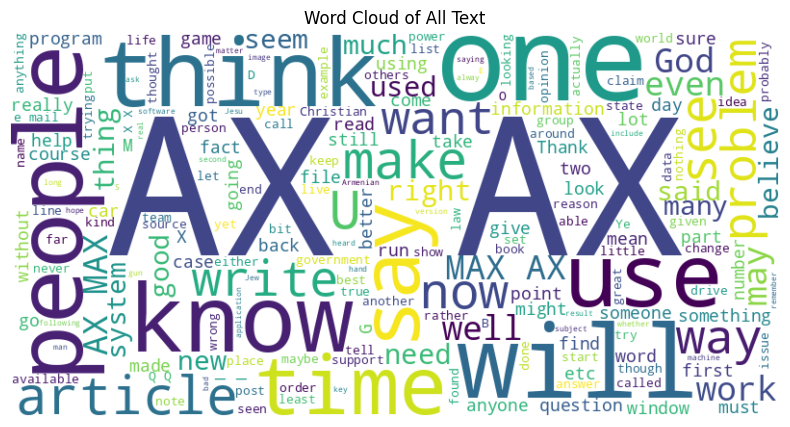

In [ ]:
from wordcloud import WordCloud

# Combine all text in the dataset
all_text = ' '.join(data['Body'])

# Generate a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Text')
plt.show()


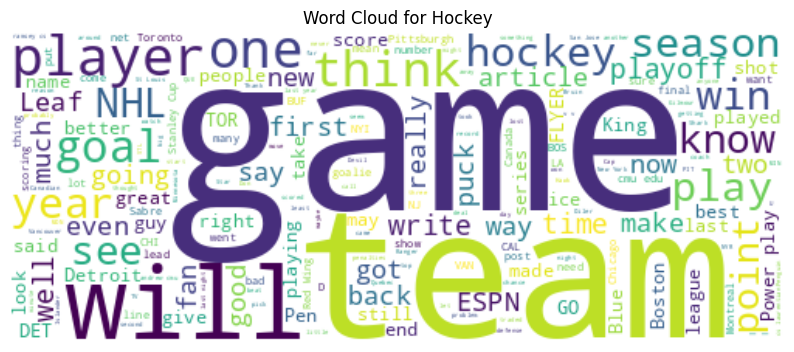

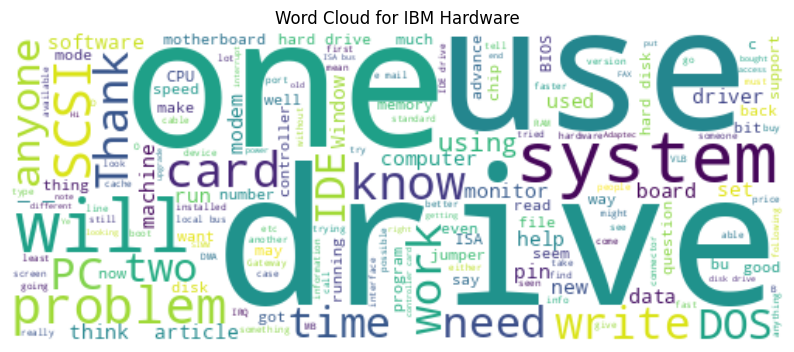

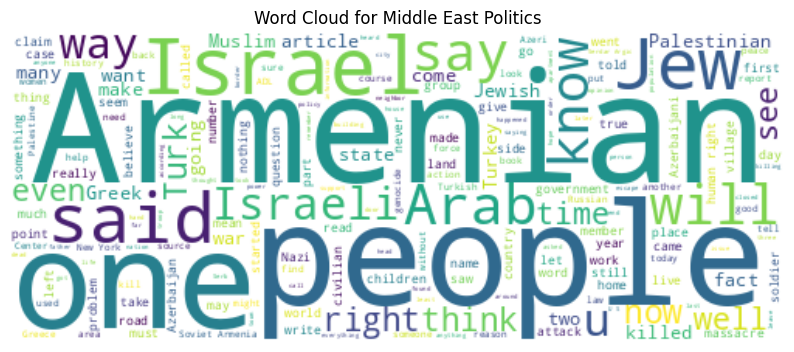

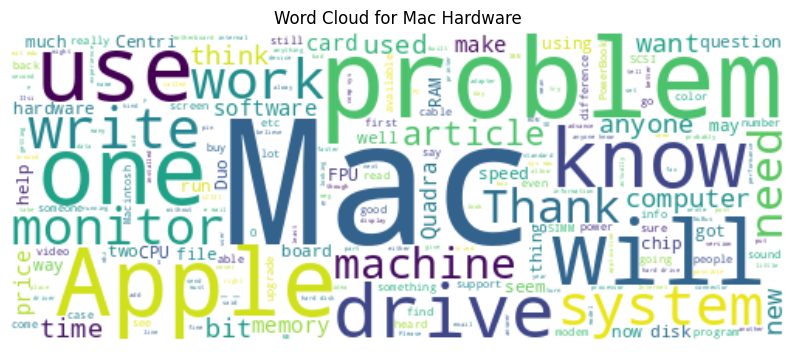

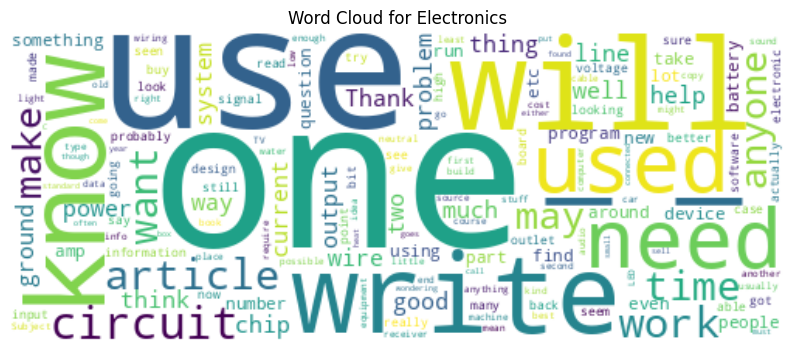

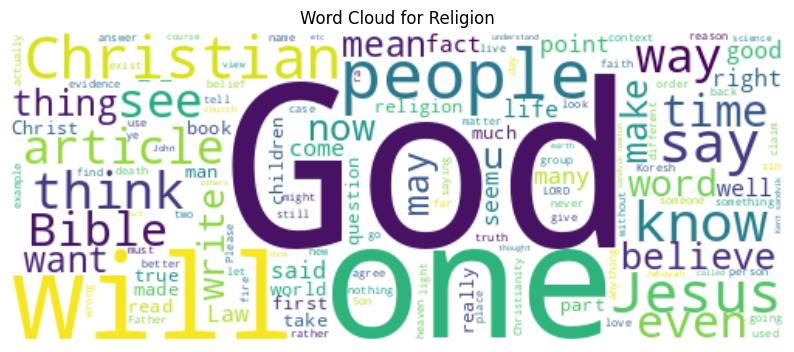

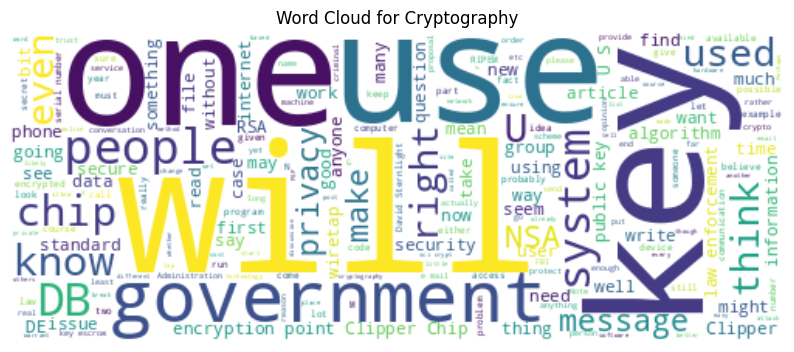

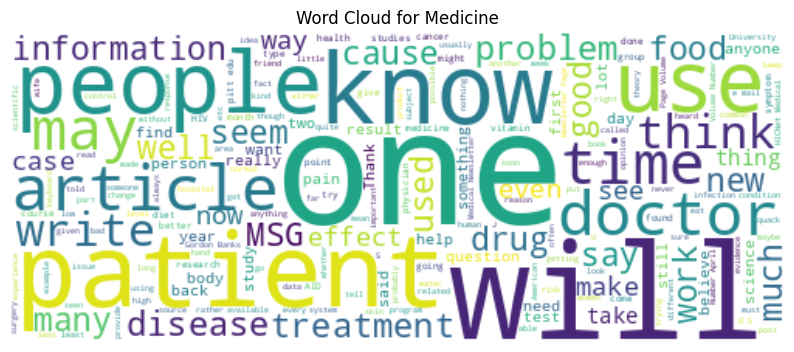

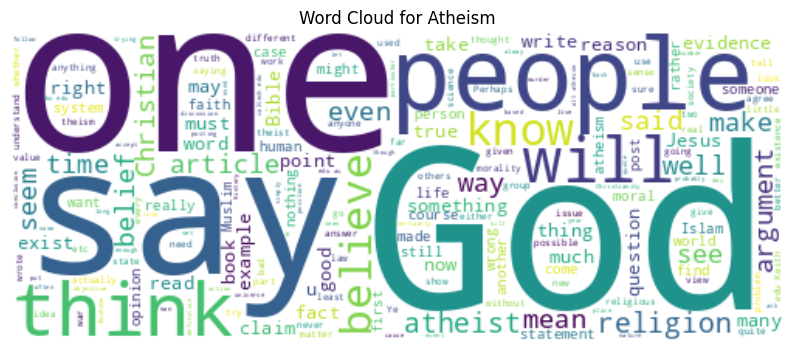

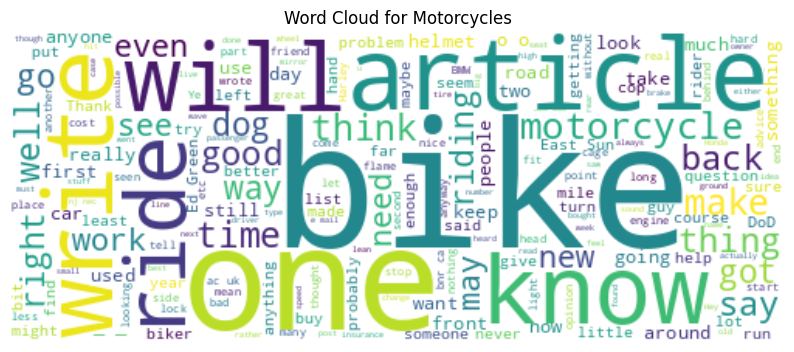

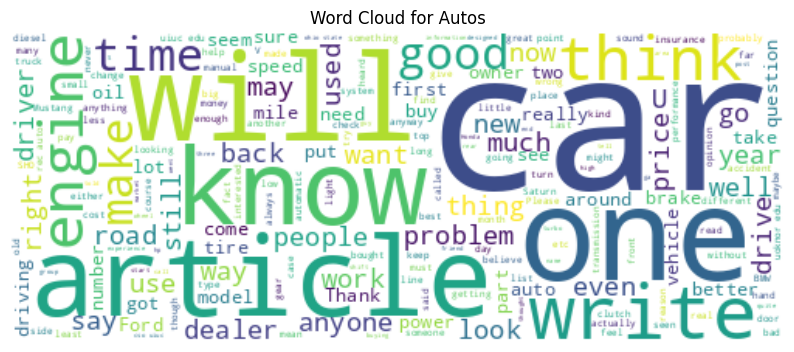

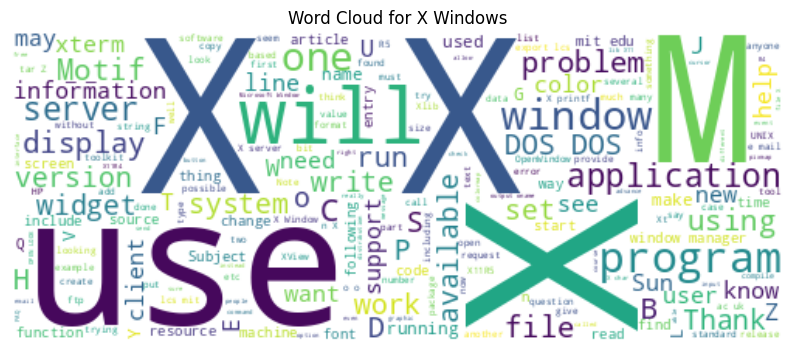

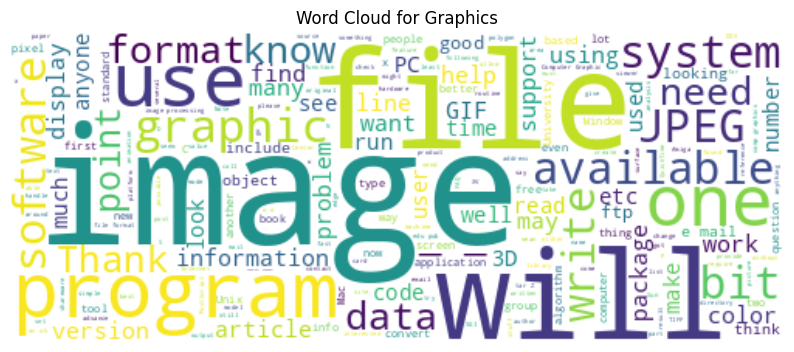

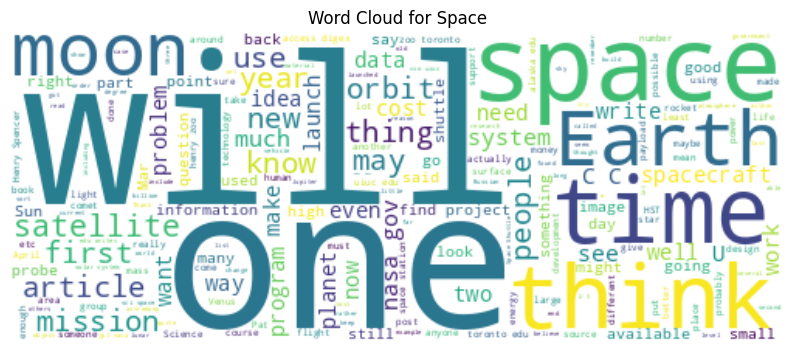

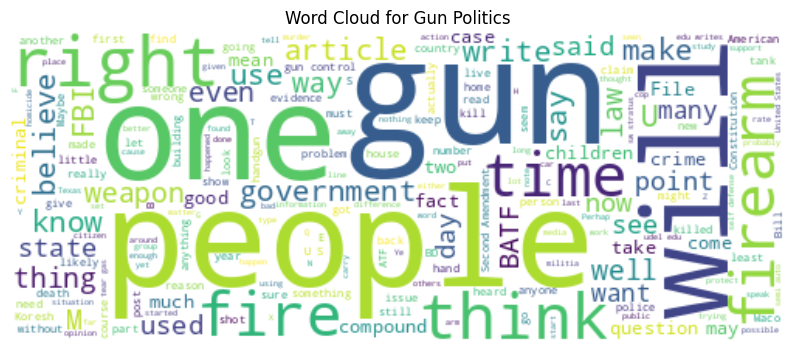

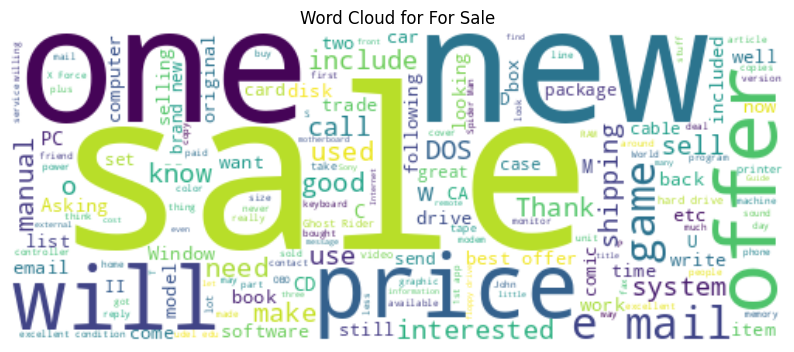

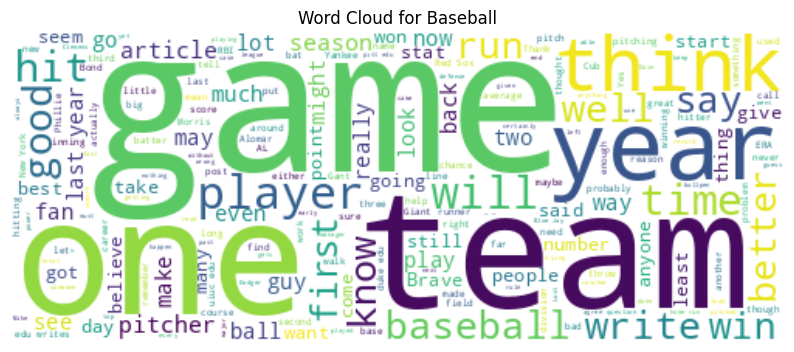

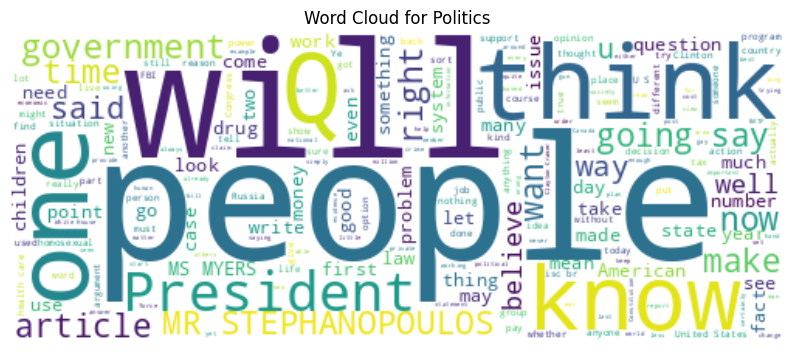

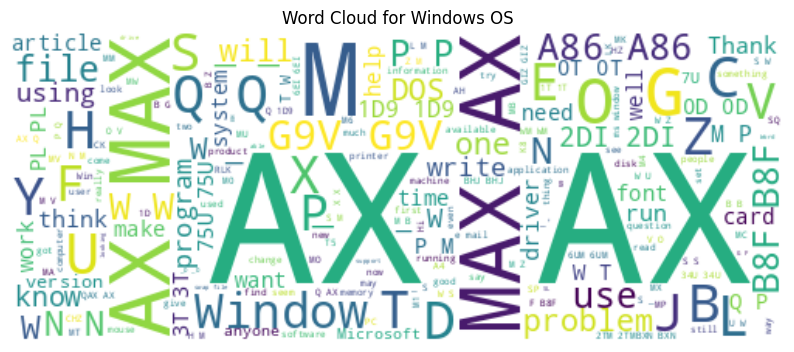

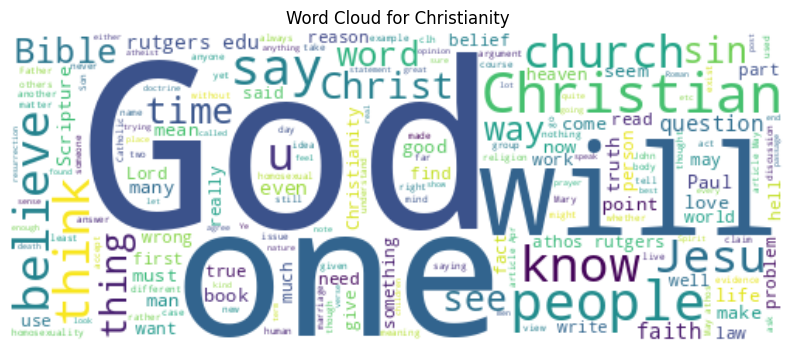

In [ ]:
categories = data['readable_category'].unique()
for category in categories:
    category_text = ' '.join(data[data['readable_category'] == category]['Body'])
    wordcloud = WordCloud(width=500, height=200, background_color='white').generate(category_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()


In [ ]:
print(data['text'].iloc[5])

From: tell@cs.unc.edu (Stephen Tell)
Subject: Re: subliminal message flashing on TV
Organization: The University of North Carolina at Chapel Hill
Lines: 25
NNTP-Posting-Host: rukbat.cs.unc.edu

In article <7480237@hpfcso.FC.HP.COM> myers@hpfcso.FC.HP.COM (Bob Myers) writes:
>> Hi.  I was doing research on subliminal suggestion for a psychology
>> paper, and I read that one researcher flashed hidden messages on the
>> TV screen at 1/200ths of a second.  Is that possible?

> Might
>even be a vector ("strokewriter") display, in which case the lower limit
>on image time is anyone's guess (and is probably phosphor-persistence limited).

Back in high school I worked as a lab assistant for a bunch of experimental
psychologists at Bell Labs.  When they were doing visual perception and
memory experiments, they used vector-type displays, with 1-millisecond
refresh rates common.

So your case of 1/200th sec is quite practical, and the experimenters were
probably sure that it was 5 milliseconds, n

In [ ]:
# Inspect the updated DataFrame
print("Updated DataFrame with extracted fields:")
print(data.head())

Updated DataFrame with extracted fields:
                                                text  target  \
0  From: Mamatha Devineni Ratnam <mr47+@andrew.cm...      10   
1  From: mblawson@midway.ecn.uoknor.edu (Matthew ...       3   
2  From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...      17   
3  From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...       3   
4  From: Alexander Samuel McDiarmid <am2o+@andrew...       4   

              text_category     readable_category  \
0          rec.sport.hockey                Hockey   
1  comp.sys.ibm.pc.hardware          IBM Hardware   
2     talk.politics.mideast  Middle East Politics   
3  comp.sys.ibm.pc.hardware          IBM Hardware   
4     comp.sys.mac.hardware          Mac Hardware   

                                                From  \
0     Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>   
1  mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)   
2                    hilmi-er@dsv.su.se (Hilmi Eren)   
3                   guyd@austin

In [ ]:
data.shape

(18846, 10)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               18846 non-null  object
 1   target             18846 non-null  int64 
 2   text_category      18846 non-null  object
 3   readable_category  18846 non-null  object
 4   From               18846 non-null  object
 5   Subject            18846 non-null  object
 6   Organization       18066 non-null  object
 7   Lines              18788 non-null  object
 8   NNTP-Posting-Host  8032 non-null   object
 9   Body               18846 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.4+ MB


In [ ]:
data.columns

Index(['text', 'target', 'text_category', 'readable_category', 'From',
       'Subject', 'Organization', 'Lines', 'NNTP-Posting-Host', 'Body'],
      dtype='object')

In [ ]:
data.isnull().sum()

text                     0
target                   0
text_category            0
readable_category        0
From                     0
Subject                  0
Organization           780
Lines                   58
NNTP-Posting-Host    10814
Body                     0
dtype: int64

In [ ]:
# Drop unnecessary columns
data = data.drop(columns=['Organization', 'Lines', 'NNTP-Posting-Host'])

# Display the updated DataFrame
print("Updated DataFrame after removing unnecessary columns:")
print(data.head())

Updated DataFrame after removing unnecessary columns:
                                                text  target  \
0  From: Mamatha Devineni Ratnam <mr47+@andrew.cm...      10   
1  From: mblawson@midway.ecn.uoknor.edu (Matthew ...       3   
2  From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...      17   
3  From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...       3   
4  From: Alexander Samuel McDiarmid <am2o+@andrew...       4   

              text_category     readable_category  \
0          rec.sport.hockey                Hockey   
1  comp.sys.ibm.pc.hardware          IBM Hardware   
2     talk.politics.mideast  Middle East Politics   
3  comp.sys.ibm.pc.hardware          IBM Hardware   
4     comp.sys.mac.hardware          Mac Hardware   

                                                From  \
0     Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>   
1  mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)   
2                    hilmi-er@dsv.su.se (Hilmi Eren)   
3                 

In [ ]:
data.isnull().sum()

text                 0
target               0
text_category        0
readable_category    0
From                 0
Subject              0
Body                 0
dtype: int64

In [ ]:
# # Text preprocessing function
import nltk

# Download the WordNet corpus
nltk.download('wordnet')

# Also, download the WordNet interface for lemmatization
nltk.download('omw-1.4')  # Required for some languages



from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, remove_stopwords=True):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])  # Lemmatization
    text = re.sub(r'\s+', ' ', text).strip()
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# # Apply preprocessing
data['Body'] = data['Body'].apply(preprocess_text, remove_stopwords=True)  # Testing without stopwords

# Verify the updated DataFrame
print(data[['Body', 'text_category', 'readable_category']].head())

                                                Body  \
0  sure bashers pen fan pretty confused lack kind...   
1  brother market highperformance video card supp...   
2  student regional killing alias davidian davidi...   
3  article aprjulianuwoca wlsmithvalveheartrriuwo...   
4  old jasmine drive cannot use new system unders...   

              text_category     readable_category  
0          rec.sport.hockey                Hockey  
1  comp.sys.ibm.pc.hardware          IBM Hardware  
2     talk.politics.mideast  Middle East Politics  
3  comp.sys.ibm.pc.hardware          IBM Hardware  
4     comp.sys.mac.hardware          Mac Hardware  


In [ ]:
data.shape

(18846, 7)

In [ ]:
data.columns

Index(['text', 'target', 'text_category', 'readable_category', 'From',
       'Subject', 'Body'],
      dtype='object')

In [ ]:
# Save the preprocessed DataFrame before splitting
data.to_csv('preprocessed_newsgroups_data.csv', index=False)
print("The preprocessed DataFrame has been saved as 'preprocessed_newsgroups_data.csv'.")

The preprocessed DataFrame has been saved as 'preprocessed_newsgroups_data.csv'.


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(data['Body'], data['target'], test_size=0.2, random_state=42)

In [ ]:
# Vectorize the text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Decision Tree

In [ ]:
# # Step 2: Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_vec, y_train)
y_pred_dt = dt_model.predict(X_test_vec)

# print("Decision Tree Classification Report")
# print(classification_report(y_test, y_pred_dt))


Decision Tree Evaluation
                          precision    recall  f1-score   support

             alt.atheism       0.53      0.52      0.52       151
           comp.graphics       0.43      0.48      0.45       202
 comp.os.ms-windows.misc       0.58      0.58      0.58       195
comp.sys.ibm.pc.hardware       0.46      0.49      0.48       183
   comp.sys.mac.hardware       0.62      0.60      0.61       205
          comp.windows.x       0.64      0.52      0.57       215
            misc.forsale       0.48      0.50      0.49       193
               rec.autos       0.64      0.64      0.64       196
         rec.motorcycles       0.70      0.79      0.75       168
      rec.sport.baseball       0.63      0.69      0.66       211
        rec.sport.hockey       0.71      0.71      0.71       198
               sci.crypt       0.73      0.68      0.70       201
         sci.electronics       0.45      0.46      0.45       202
                 sci.med       0.68      0.68     

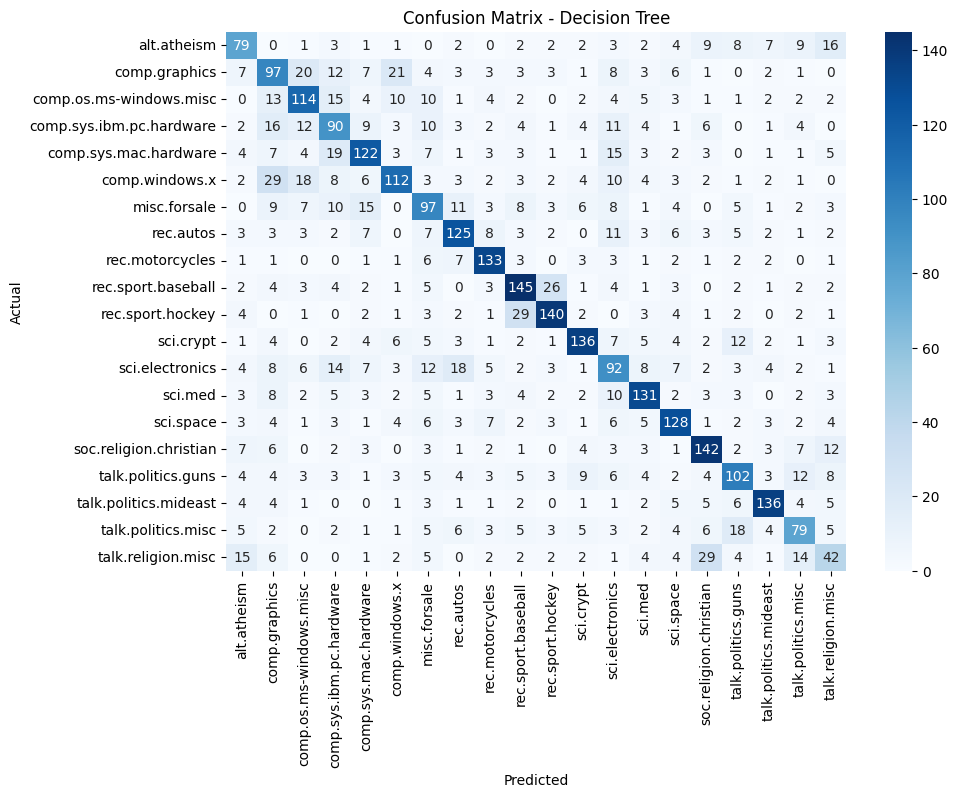

In [ ]:
#Decision Tree confusion matrix
print("Decision Tree Evaluation")
print(classification_report(y_test, y_pred_dt, target_names=newsgroups.target_names))
plot_confusion_matrix(y_test, y_pred_dt, newsgroups.target_names, "Decision Tree")

RNN

In [ ]:
from tensorflow.keras.layers import Bidirectional

# Tokenization and Padding for RNN
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

# Step 3: RNN Model
rnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(len(newsgroups.target_names), activation='softmax')
])
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = rnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])

# Evaluate the RNN model
loss, accuracy = rnn_model.evaluate(X_test_pad, y_test)
print(f"RNN Test Accuracy: {accuracy}")

# Generate predictions for the test set using the RNN model
rnn_predictions = rnn_model.predict(X_test_pad)
rnn_predicted_classes = np.argmax(rnn_predictions, axis=1)  # Convert probabilities to class labels



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


472/472 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.1240 - loss: 2.6536 - val_accuracy: 0.2721 - val_loss: 2.2926
Epoch 2/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 496s 1s/step - accuracy: 0.3893 - loss: 1.7572 - val_accuracy: 0.5448 - val_loss: 1.3080
Epoch 3/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.6393 - loss: 1.0483 - val_accuracy: 0.6477 - val_loss: 1.0705
Epoch 4/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.7687 - loss: 0.7006 - val_accuracy: 0.7183 - val_loss: 0.9314
Epoch 5/5
472/472 ━━━━━━━━━━━━━━━━━━━━ 557s 1s/step - accuracy: 0.8624 - loss: 0.4505 - val_accuracy: 0.7390 - val_loss: 0.9340
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 288ms/step - accuracy: 0.7084 - loss: 0.9781
RNN Test Accuracy: 0.7183023691177368
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 291ms/step


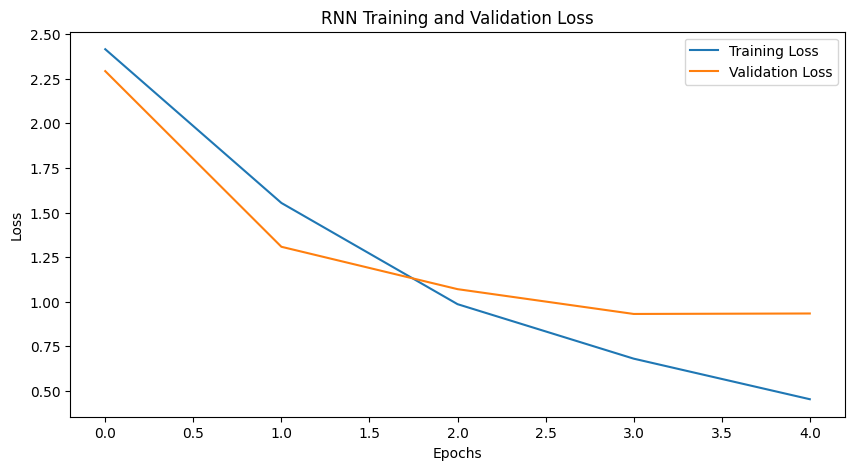

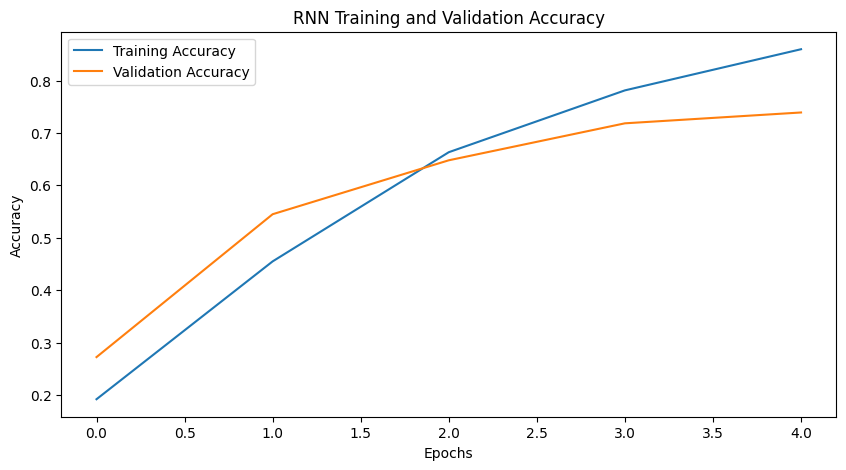

In [ ]:
# Visualizing RNN Training History
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

RNN Evaluation
                          precision    recall  f1-score   support

             alt.atheism       0.60      0.77      0.68       151
           comp.graphics       0.66      0.58      0.62       202
 comp.os.ms-windows.misc       0.69      0.62      0.65       195
comp.sys.ibm.pc.hardware       0.53      0.55      0.54       183
   comp.sys.mac.hardware       0.57      0.66      0.62       205
          comp.windows.x       0.69      0.77      0.73       215
            misc.forsale       0.72      0.61      0.66       193
               rec.autos       0.80      0.78      0.79       196
         rec.motorcycles       0.90      0.84      0.87       168
      rec.sport.baseball       0.86      0.76      0.81       211
        rec.sport.hockey       0.82      0.91      0.87       198
               sci.crypt       0.79      0.84      0.81       201
         sci.electronics       0.61      0.52      0.56       202
                 sci.med       0.73      0.85      0.79     

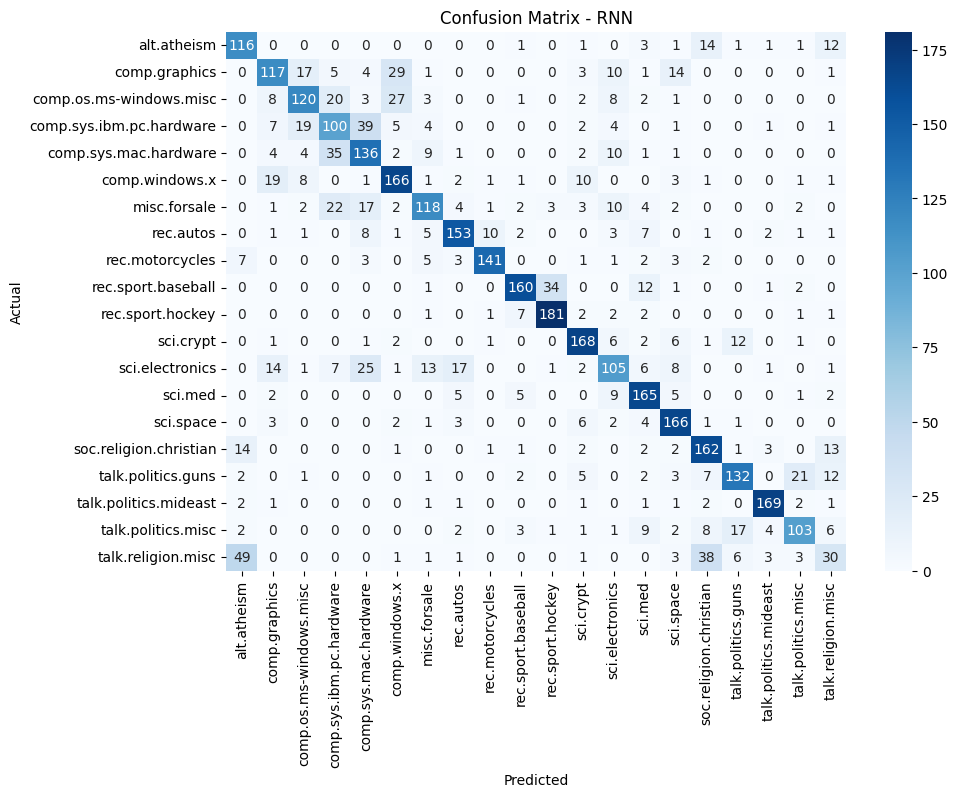

In [ ]:
#RNN confusion matrix
# Confusion Matrix and Classification Report for RNN
print("RNN Evaluation")
print(classification_report(y_test, rnn_predicted_classes, target_names=newsgroups.target_names))
plot_confusion_matrix(y_test, np.argmax(rnn_predictions, axis=1), newsgroups.target_names, "RNN")


Decision Tree with RNN Features

472/472 ━━━━━━━━━━━━━━━━━━━━ 137s 291ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 299ms/step
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}
Decision Tree with RNN Features - Best Model Evaluation
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       151
           1       0.59      0.62      0.60       202
           2       0.62      0.63      0.62       195
           3       0.46      0.55      0.50       183
           4       0.58      0.62      0.60       205
           5       0.76      0.67      0.71       215
           6       0.60      0.59      0.60       193
           7       0.72      0.77      0.74       196
           8       0.93      0.83      0.87       168
           9       0.82      0.83      0.83       211
          10       0.90      0.86      0.88       198
          11       0.84      0.83      0

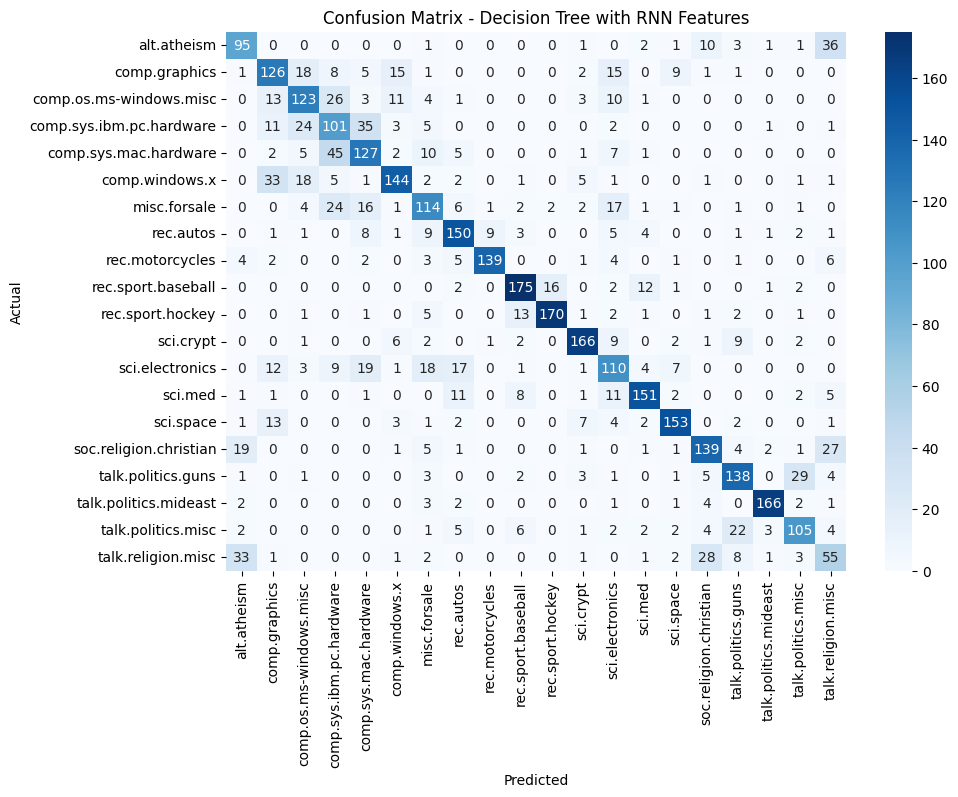

    mean_test_score  std_test_score  \
16         0.857654        0.005975   
15         0.857654        0.005975   
17         0.857654        0.005975   
34         0.856394        0.007202   
35         0.856394        0.007202   
..              ...             ...   
4          0.583378        0.003087   
3          0.583378        0.003087   
2          0.581322        0.003920   
1          0.580724        0.003937   
0          0.579995        0.003486   

                                               params  
16  {'criterion': 'gini', 'max_depth': 20, 'min_sa...  
15  {'criterion': 'gini', 'max_depth': 20, 'min_sa...  
17  {'criterion': 'gini', 'max_depth': 20, 'min_sa...  
34  {'criterion': 'gini', 'max_depth': None, 'min_...  
35  {'criterion': 'gini', 'max_depth': None, 'min_...  
..                                                ...  
4   {'criterion': 'gini', 'max_depth': 10, 'min_sa...  
3   {'criterion': 'gini', 'max_depth': 10, 'min_sa...  
2   {'criterion': 'gini', '

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# # Extract features from the RNN
rnn_features_train = rnn_model.predict(X_train_pad)
rnn_features_test = rnn_model.predict(X_test_pad)

# # Scale the RNN features
scaler = StandardScaler()
rnn_features_train_scaled = scaler.fit_transform(rnn_features_train)
rnn_features_test_scaled = scaler.transform(rnn_features_test)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [10, 20, 30, None],        # Maximum depth of the tree
    'min_samples_split': [2, 10, 20],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 5, 10],        # Minimum samples required to be at a leaf node
    'criterion': ['gini', 'entropy']       # Criterion for splitting ('gini' or 'entropy')
}

# Initialize the Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5,                 # Use 5-fold cross-validation
    scoring='accuracy',   # Scoring metric to evaluate model performance
    n_jobs=-1,            # Use all available cores for parallel processing
    verbose=1             # Output progress of GridSearch
)

# Fit GridSearchCV using the scaled RNN features
grid_search.fit(rnn_features_train_scaled, y_train)

# Extract the best estimator (Decision Tree with the best hyperparameters)
dt_model_rnn = grid_search.best_estimator_

# Print the best hyperparameters
print(f"Best Parameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred_dt_rnn = dt_model_rnn.predict(rnn_features_test_scaled)

# Evaluate the model
print("Decision Tree with RNN Features - Best Model Evaluation")
print(classification_report(y_test, y_pred_dt_rnn))

# Plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Call the confusion matrix plotting function
plot_confusion_matrix(y_test, y_pred_dt_rnn, labels=newsgroups.target_names, model_name="Decision Tree with RNN Features")

# Optional: Print cross-validation results
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['mean_test_score', 'std_test_score', 'params']].sort_values(by='mean_test_score', ascending=False))


In [ ]:
# Function to preprocess custom input text
def preprocess_custom_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    stop_words = set(stopwords.words('english'))  # Tokenize and remove stopwords
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in tokens])  # Lemmatize
    return lemmatized_text

# Function to predict custom input using all models
def predict_custom_text(input_text):
    # Preprocess the input text
    preprocessed_text = preprocess_custom_text(input_text)

    # ---- Decision Tree Prediction ----
    tfidf_input = vectorizer.transform([preprocessed_text])  # Transform text using TFIDF
    dt_prediction = dt_model.predict(tfidf_input)[0]  # Predict with Decision Tree
    dt_category = newsgroups.target_names[dt_prediction]

    # ---- RNN Prediction ----
    tokenized_input = tokenizer.texts_to_sequences([preprocessed_text])  # Tokenize
    padded_input = pad_sequences(tokenized_input, maxlen=200)  # Pad the sequence
    rnn_prediction = rnn_model.predict(padded_input)  # Predict with RNN
    rnn_category = newsgroups.target_names[np.argmax(rnn_prediction)]  # Get category

    # ---- Decision Tree with RNN Features Prediction ----
    rnn_features_input = rnn_model.predict(padded_input)  # Extract RNN features
    scaled_rnn_features = scaler.transform(rnn_features_input)  # Scale RNN features
    dt_rnn_prediction = dt_model_rnn.predict(scaled_rnn_features)[0]  # Predict with Decision Tree using RNN features
    dt_rnn_category = newsgroups.target_names[dt_rnn_prediction]

    # Print predictions
    print("\nCustom Input Prediction:")
    print(f"Input Text: {input_text}")
    print(f"Decision Tree Category: {dt_category}")
    print(f"RNN Category: {rnn_category}")
    print(f"Decision Tree with RNN Features Category: {dt_rnn_category}")

# Example of predicting custom text
input_text_1 = "Quantum computers pose a significant risk to existing encryption systems."
input_text_2 = "Blockchain technology is revolutionizing secure online transactions."

# Predict categories for custom texts
predict_custom_text(input_text_1)
predict_custom_text(input_text_2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step

Custom Input Prediction:
Input Text: Quantum computers pose a significant risk to existing encryption systems.
Decision Tree Category: sci.crypt
RNN Category: sci.crypt
Decision Tree with RNN Features Category: comp.windows.x
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step

Custom Input Prediction:
Input Text: Blockchain technology is revolutionizing secure online transactions.
Decision Tree Category: comp.sys.mac.hardware
RNN Category: sci.crypt
Decision Tree with RNN Features Category: misc.forsale
